C:\Users\Younas\AppData\Local\Temp\ipykernel_13084\4264501078.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



Dataset loaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_13084\4264501078.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may 

NLTK data downloaded.


Epoch 1/10


134/134 [==============================] - 64s 371ms/step - loss: 0.5050 - accuracy: 0.7435 - val_loss: 0.4969 - val_accuracy: 0.7516
Epoch 2/10
134/134 [==============================] - 38s 281ms/step - loss: 0.3355 - accuracy: 0.8588 - val_loss: 0.3594 - val_accuracy: 0.8698
Epoch 3/10
58/58 [==============================] - 2s 23ms/step
Epoch 1/10
134/134 [==============================] - 45s 334ms/step - loss: 0.4782 - accuracy: 0.7699 - val_loss: 0.3497 - val_accuracy: 0.8617
Epoch 2/10
134/134 [==============================] - 41s 305ms/step - loss: 0.3087 - accuracy: 0.8728 - val_loss: 0.2569 - val_accuracy: 0.9160
Epoch 3/10
134/134 [==============================] - 56s 418ms/step - loss: 0.2392 - accuracy: 0.9071 - val_loss: 0.2056 - val_accuracy: 0.9529
Epoch 4/10
58/58 [==============================] - 4s 55ms/step
Epoch 1/10
134/134 [==============================] - 54s 404ms/step - loss: 0.4698 - accuracy: 0.7801 - val_loss: 0.55

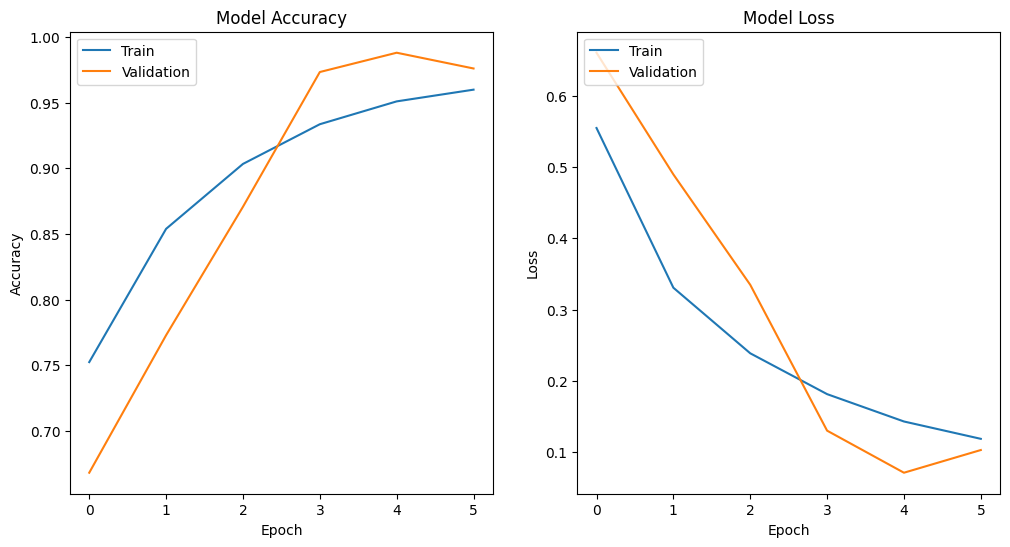

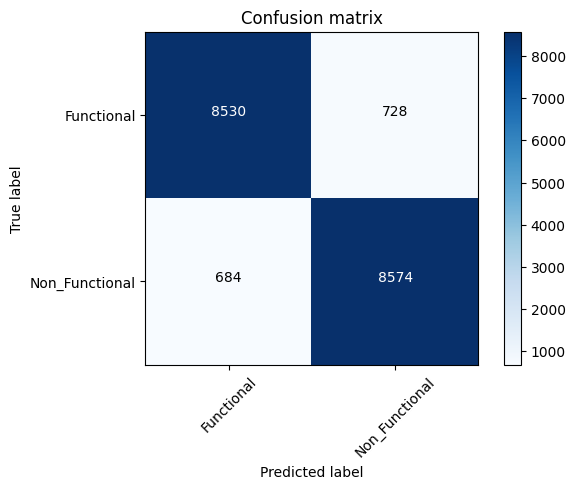

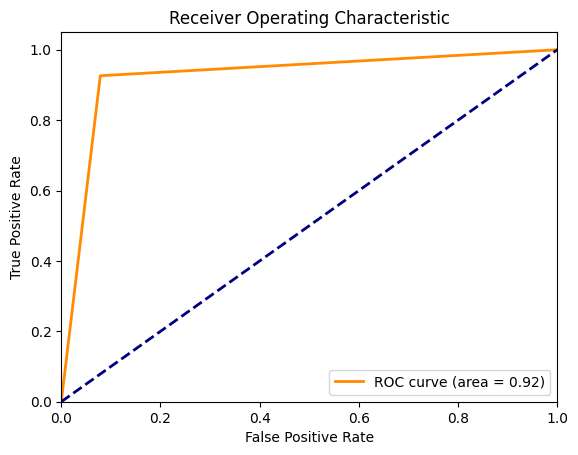

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      9258
           1       0.92      0.93      0.92      9258

    accuracy                           0.92     18516
   macro avg       0.92      0.92      0.92     18516
weighted avg       0.92      0.92      0.92     18516



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the GRU model
def build_GRU_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# Instantiate the model
gru_model = build_GRU_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = gru_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = gru_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Younas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
C:\Users\Younas\AppData\Local\Temp\ipykernel_13084\748634121.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may w

Epoch 1/10
11/11 [==============================] - 7s 300ms/step - loss: 0.6790 - accuracy: 0.6032 - val_loss: 0.8386 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 20ms/step
Epoch 1/10
11/11 [==============================] - 3s 248ms/step - loss: 0.6500 - accuracy: 0.6313 - val_loss: 1.0062 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 20ms/step
Epoch 1/10
11/11 [==============================] - 3s 255ms/step - loss: 0.6266 - accuracy: 0.6326 - val_loss: 0.9198 - val_accuracy: 0.0861
Epoch 2/10
11/11 [==============================] - 3s 240ms/step - loss: 0.5639 - accuracy: 0.7132 - val_loss: 0.7914 - val_accuracy: 0.4906
Epoch 3/10
11/11 [==============================] - 3s 241ms/step - loss: 0.4842 - accuracy: 0.7816 - val_loss: 0.6946 - val_accuracy: 0.6180
Epoch 4/10
5/5 [==============================] - 0s 21ms/step
Epoch 1/10
11/11 [==============================] - 3s 254ms/step - loss: 0.5839 - accuracy: 

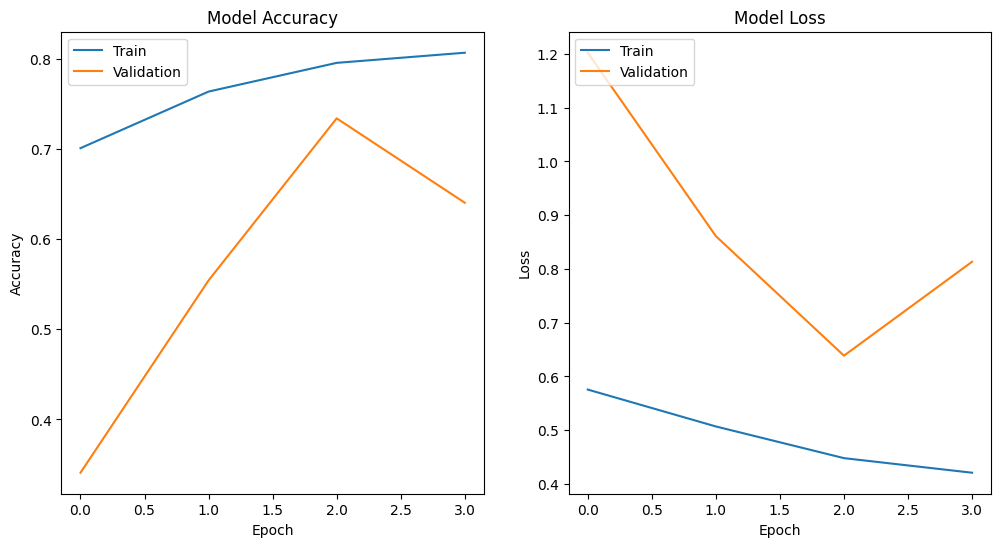

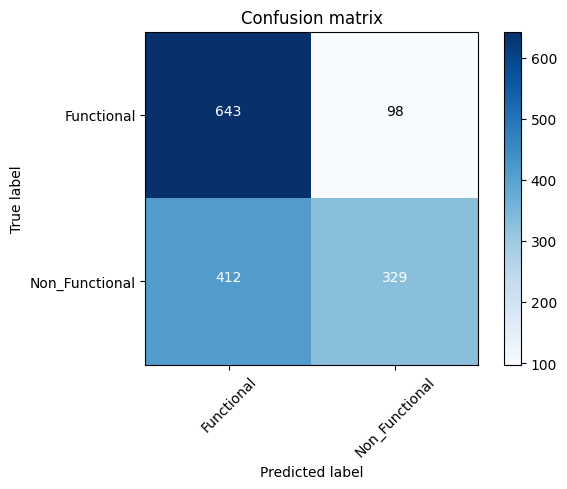

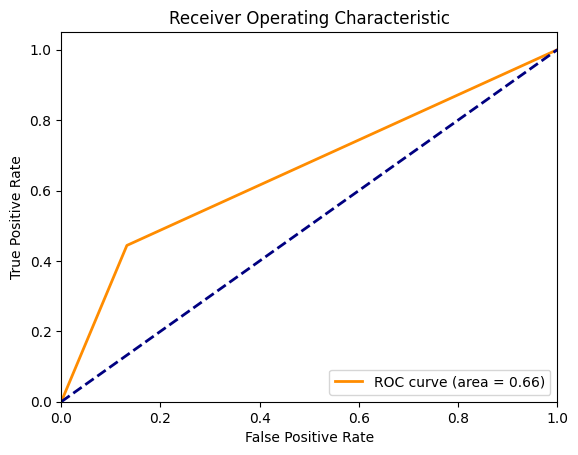

              precision    recall  f1-score   support

           0       0.61      0.87      0.72       741
           1       0.77      0.44      0.56       741

    accuracy                           0.66      1482
   macro avg       0.69      0.66      0.64      1482
weighted avg       0.69      0.66      0.64      1482



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('Binary_Classification.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Annotation'] = dataset['Annotation'].map({'Functional': 1, 'Non_Functional': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Annotation']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the GRU model
def build_GRU_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

# Instantiate the model
gru_model = build_GRU_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 10
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = gru_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = gru_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["Functional", "Non_Functional"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))
